* predict whether a person -in a certain setup- will donate blood or not
* we hava data of persons/situations and the outcome: donation or not
* facing blood need, we can therefore assess how likely our database donors will give blood NOW and target the most likely to
* so we are predicting people's behaviours in a blood donation situation, based on past behaviours
* data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('transfusion.data')

In [124]:
data.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
data.shape

(748, 5)

In [4]:
data['whether he/she donated blood in March 2007'] = data['whether he/she donated blood in March 2007'].astype(str)

In [53]:
data['whether he/she donated blood in March 2007'].value_counts()

0    570
1    178
Name: whether he/she donated blood in March 2007, dtype: int64

* there is a 1:3 balance between our two classes

In [46]:
data.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months)
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


* no missing values
* Time (months): months passed since first donation 
* Recency (months): months passed since last donation
* Frequency (times): number of donations
* Monetary (c.c. blood): total number of cubic centimeters of blood donated, maybe convert?


In [79]:
data.columns

Index(['Recency (months)', 'Frequency (times)', 'Monetary (c.c. blood)',
       'Time (months)', 'whether he/she donated blood in March 2007'],
      dtype='object')

In [5]:
data.rename(columns= {'Time (months)': 'months_since_first',
                      'Recency (months)': 'months_since_last', 
                      'Frequency (times)': 'number_of_donations',
                      'Monetary (c.c. blood)': 'total_blood_donated',
                      'whether he/she donated blood in March 2007': 'donated'
                     }, inplace= True)

data = data[['months_since_first', 'months_since_last', 'number_of_donations',
             'total_blood_donated', 'donated']]
data.head()

,months_since_first,months_since_last,number_of_donations,total_blood_donated,donated
0,98,2,50,12500,1
1,28,0,13,3250,1
2,35,1,16,4000,1
3,45,2,20,5000,1
4,77,1,24,6000,0


# Data viz

In [12]:
%matplotlib inline 

import matplotlib as mpl

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [16]:
mpl.style.use('ggplot')

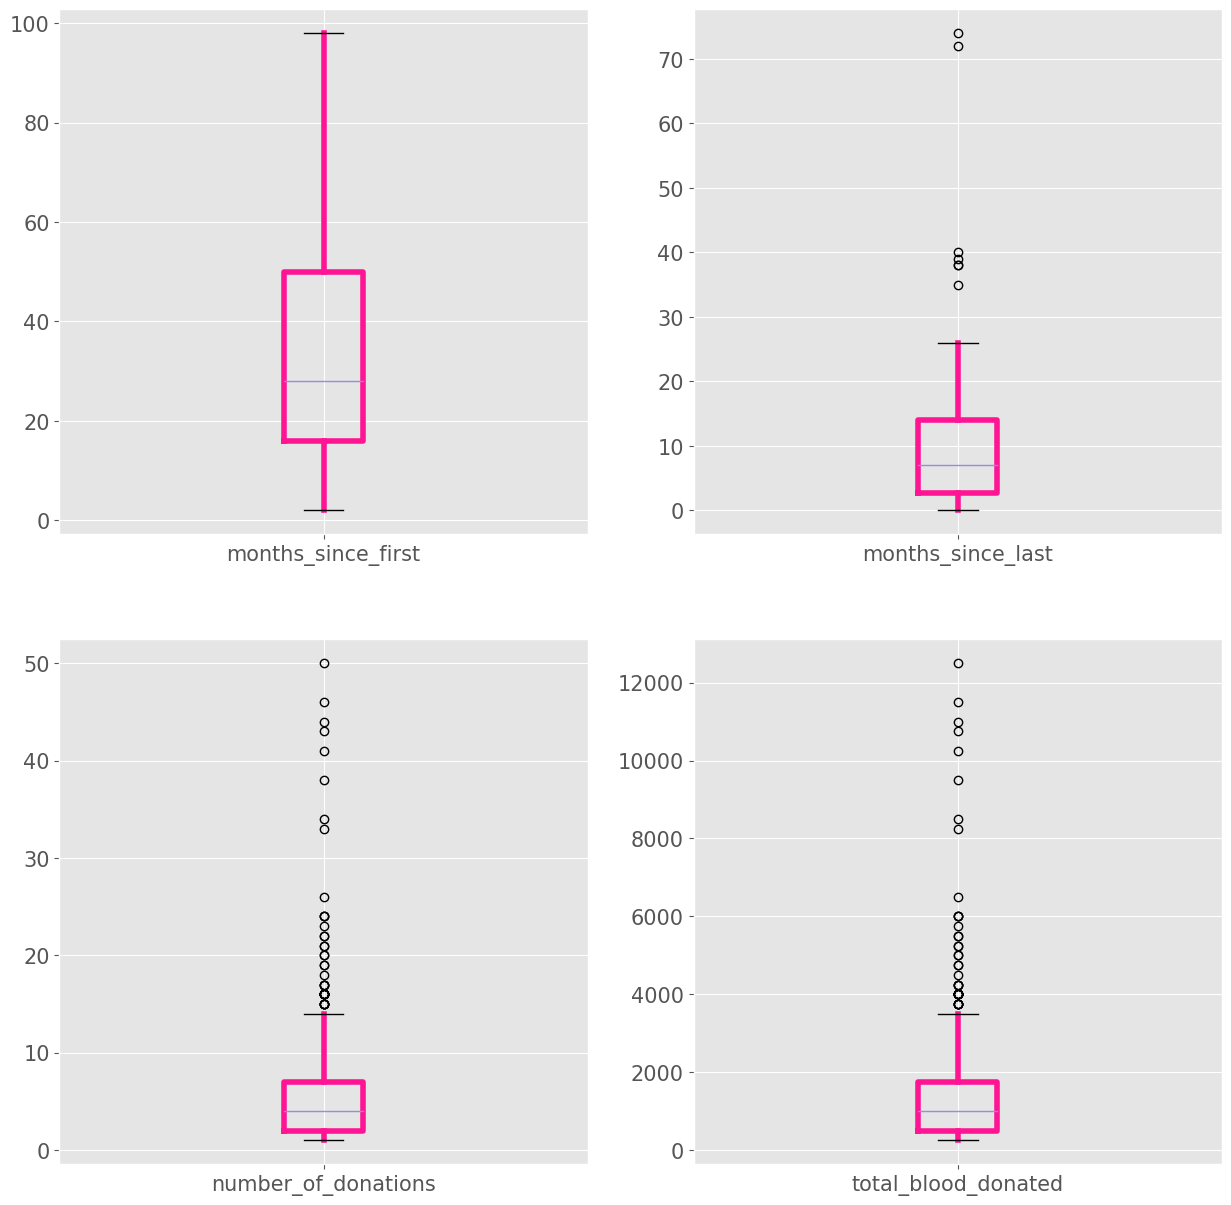

In [55]:
plt.figure(figsize= (15,15))

boxprops = dict(linestyle= '-', linewidth= 4, color= 'deeppink')

whiskerprops = dict(linestyle= '-', linewidth= 4, color= 'deeppink')

for i in range(1, len(data.columns)):
    
    ax = plt.subplot(2, 2, i)
    
    data.boxplot(column= data.columns[i-1],
                 fontsize= 15,
                 boxprops= boxprops,
                 whiskerprops= whiskerprops,
                 ax=ax
                )
    
plt.show()

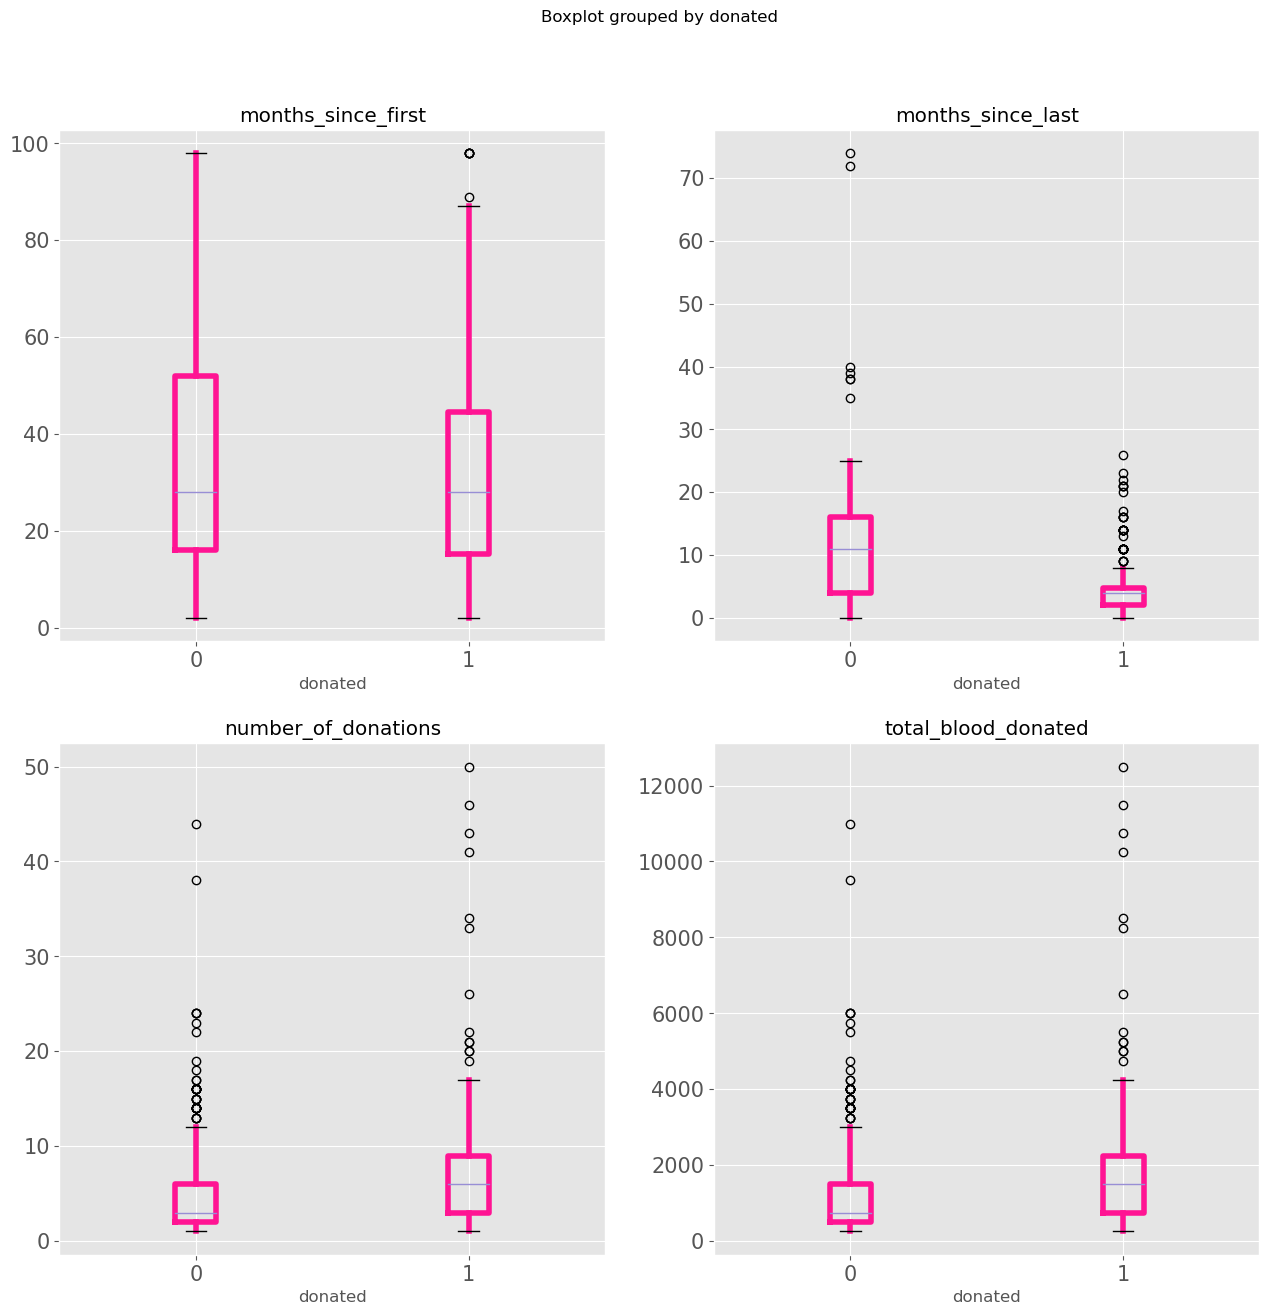

In [56]:
# features by target

plt.figure(figsize= (15,15))

boxprops = dict(linestyle= '-', linewidth= 4, color= 'deeppink')

whiskerprops = dict(linestyle= '-', linewidth= 4, color= 'deeppink')

for i in range(1, len(data.columns)):
    
    ax = plt.subplot(2, 2, i)
    
    data.boxplot(column= data.columns[i-1],
                 by= 'donated',
                 fontsize= 15,
                 boxprops= boxprops,
                 whiskerprops= whiskerprops,
                 ax=ax
                )
    
plt.show()

* **months passed since first donation** seems to have the same distribution at both classes
* donors seem to be linked with smaller values of **months passed since last donation** compared to non donors: can we say that ppl are more likely to donate blood after fewer time since last donation?
* **number of donations and blood donated** have more important values within the donated class

==> **donor profile**: has significant amount of past donations and it has not been a while since he last donated?

# Data preprocessing

In [6]:
from sklearn import preprocessing

In [7]:
# outliers handling

# define outliers based on percentiles

def save_col_outliers(col):
    
    upper_lim = data[col].quantile(.95)
    lower_lim = data[col].quantile(.05)
    
    print(col, '\n')
    print(upper_lim)
    print(lower_lim)
    print(data[(data[col] < lower_lim) | (data[col] > upper_lim)].shape, '\n')
    
    return data[(data[col] < lower_lim) | (data[col] > upper_lim)].index.values.tolist()


outliers_indexes = []

for col in data.columns[:-1]:
    
    outliers_indexes.extend(save_col_outliers(col))

outliers_indexes = set(outliers_indexes)

len(outliers_indexes)

months_since_first 

82.64999999999998
4.0
(75, 5) 

months_since_last 

23.0
2.0
(23, 5) 

number_of_donations 

16.0
1.0
(26, 5) 

total_blood_donated 

4000.0
250.0
(26, 5) 



112

In [8]:
# drop outliers rows

new_data = data[~data.index.isin(outliers_indexes)]

new_data.shape

(636, 5)

In [9]:
# *** this is a transform cell ***

# convert blood donated to liters as a scaling way

new_data['total_blood_donated'] /= 1000

new_data[['total_blood_donated']].describe()

/tmp/ipykernel_13566/429274637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['total_blood_donated'] /= 1000


,total_blood_donated
count,636.000000
mean,1.164701
std,0.885411
min,0.250000
25%,0.500000
50%,1.000000
75%,1.500000
max,4.000000


In [10]:
# *** this is a transform cell ***

# normalization

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(new_data[new_data.columns[:-2]])

#print(min_max_scaler.data_max_)

new_data[new_data.columns[:-2]] = min_max_scaler.transform(new_data[new_data.columns[:-2]])

new_data.describe()

/tmp/ipykernel_13566/427010661.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[new_data.columns[:-2]] = min_max_scaler.transform(new_data[new_data.columns[:-2]])


,months_since_first,months_since_last,number_of_donations,total_blood_donated
count,636.000000,636.000000,636.000000,636.000000
mean,0.354499,0.363357,0.243920,1.164701
std,0.254520,0.327918,0.236110,0.885411
min,0.000000,0.000000,0.000000,0.250000
25%,0.153846,0.095238,0.066667,0.500000
50%,0.301282,0.333333,0.200000,1.000000
75%,0.525641,0.571429,0.333333,1.500000
max,1.000000,1.000000,1.000000,4.000000


# Modeling and evaluation

In [11]:
from sklearn.model_selection import train_test_split

from sklearn import svm

from sklearn import metrics

In [12]:
# split data

x_train, x_test, y_train, y_test = train_test_split(new_data.loc[:, new_data.columns != 'donated'], 
                                                  new_data[['donated']], 
                                                  test_size= 0.2, 
                                                  random_state= 1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(508, 4)
(128, 4)
(508, 1)
(128, 1)


In [12]:
y_train.value_counts()

donated
0          383
1          125
dtype: int64

In [13]:
# fit a SVM

svm_clf = svm.SVC(C= 1, #tradeoff param between margin size and separation correctness
              kernel= 'linear',
              class_weight= 'balanced', #assign weights to classes based on the data balance
              random_state= 1)

svm_clf.fit(x_train, y_train)

/home/marwen/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, class_weight='balanced', kernel='linear', random_state=1)

In [14]:
# predict

y_pred = svm_clf.predict(x_test)

In [15]:
y_pred

array(['1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0',
       '1', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1',
       '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0',
       '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1',
       '0', '1', '1', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0',
       '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0',
       '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0'],
      dtype=object)

In [15]:
print('Confusion Matrix:', metrics.confusion_matrix(y_test, y_pred))
                                                                        
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

print('Precision:', metrics.precision_score(y_test, y_pred, pos_label= '1'))

print('Recall:', metrics.recall_score(y_test, y_pred, pos_label= '1'))

Confusion Matrix: [[62 42]
 [ 7 17]]
Accuracy: 0.6171875
Precision: 0.288135593220339
Recall: 0.7083333333333334


* Can we say that in this problem, recall is more important than precision?: Recommending more clients with non-donors is better than fewer but solid recommendations. This may be true if phone calls time is not crucial and potential donors number needs to be maximized.

# Serving

In [1]:
# create a data input class with a transform method for new data input

class Data_input:
    
    def __init__(self, months_since_first, months_since_last, number_of_donations, 
                 total_blood_donated):
        
        self.months_since_first = months_since_first
        self.months_since_last = months_since_last
        self.number_of_donations = number_of_donations
        self.total_blood_donated = total_blood_donated
    
    def print_data(self):
        
        print(f'months_since_first: {self.months_since_first}', 
              f'months_since_last: {self.months_since_last}',
              f'number_of_donations: {self.number_of_donations}',
              f'total_blood_donated: {self.total_blood_donated}',
              sep= '\n')
        
    def transform(self, min_max_scaler):
        
        # scale features

        new_data_input = min_max_scaler.transform([[self.months_since_first,
                                                   self.months_since_last,
                                                   self.number_of_donations]]).tolist()
        # convert blood to liter
        
        new_data_input[0].append(self.total_blood_donated / 1000)
        
        
        return(new_data_input)

In [22]:
data.loc[100,:]

months_since_first       34
months_since_last         4
number_of_donations       8
total_blood_donated    2000
donated                   1
Name: 100, dtype: object

In [23]:
new_data.loc[100,:]

months_since_first     0.384615
months_since_last      0.095238
number_of_donations    0.466667
total_blood_donated         2.0
donated                       1
Name: 100, dtype: object

In [5]:
x = Data_input(True, 4, 8, 2000)

x.print_data()

months_since_first: True
months_since_last: 4
number_of_donations: 8
total_blood_donated: 2000


In [26]:
x.transform(min_max_scaler)

/home/marwen/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[[0.38461538461538464, 0.09523809523809523, 0.4666666666666667, 2.0]]

In [30]:
svm_clf.predict(x.transform(min_max_scaler))[0]

/home/marwen/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/marwen/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


'1'

# Saving

In [ ]:
import pickle

In [17]:
# save data scaler

with open('scaler.pkl', 'wb') as f:
    
    pickle.dump(min_max_scaler, f)
    f.close()

In [18]:
# save model

with open('model.pkl', 'wb') as f:
    
    pickle.dump(svm_clf, f)
    f.close()